<a href="https://colab.research.google.com/github/pjcroxas/Talent-Retention-in-Railway-Workforce/blob/main/Unraveling_Railway_Employee_Turnover_A_Data_Driven_Approach_Using_Propensity_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os, math
import matplotlib.ticker as mtick
from matplotlib import style
import warnings
from google.colab import drive

drive.mount('/content/drive')
warnings.simplefilter(action='ignore', category=FutureWarning)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
dir = "/content/drive/My Drive/Data Science Portfolio/2024/Talent Retention"

In [51]:
dir = "/content/drive/My Drive/Data Science Portfolio/2024/Talent Retention"
retention_df = pd.read_excel(dir+"/talent-retention-dataset.xlsx")
retention_df.sample(3)

,Age,Sex,HighestEducationalAttainment,YearsofService,Occupation,Organization,NatureofEmployment,JF1,JF2,JL1,...,RM11,ITL1,ITS1,ITS2,ITS3,ITS4,ITL2,ITS5,ITS6,ITL3
120,46-50,Male,Bachelor's Degree,21-25 Years,Train Driver,Metro Rail Transit 3 (DOTr-MRT3),Contractual,5,5,5,...,3,2,3,3,3,3,2,4,3,3
133,46-50,Male,Bachelor's Degree,16-20 Years,train driver,Metro Rail Transit 3 (DOTr-MRT3),Contractual,4,4,4,...,4,5,4,4,4,5,3,5,5,4
116,46-50,Male,Bachelor's Degree,1-5 Years,Train Driver,Metro Rail Transit 3 (DOTr-MRT3),Contractual,3,3,2,...,3,5,5,4,5,5,5,5,5,5


In [52]:
retention_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 54 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Age                           282 non-null    object
 1   Sex                           282 non-null    object
 2   HighestEducationalAttainment  282 non-null    object
 3   YearsofService                282 non-null    object
 4   Occupation                    281 non-null    object
 5   Organization                  282 non-null    object
 6   NatureofEmployment            282 non-null    object
 7   JF1                           282 non-null    int64 
 8   JF2                           282 non-null    int64 
 9   JL1                           282 non-null    int64 
 10  JL2                           282 non-null    int64 
 11  JS1                           282 non-null    int64 
 12  JS2                           282 non-null    int64 
 13  CF1                 

### Defining the Talent Retention Questionnaire

1. `Talent Management` - refers to the general practices in the human resources industry to manage ideal workforce or people in an organization. This includes trainings, social and monetary benefits, talent pipeline and career pathway etc.

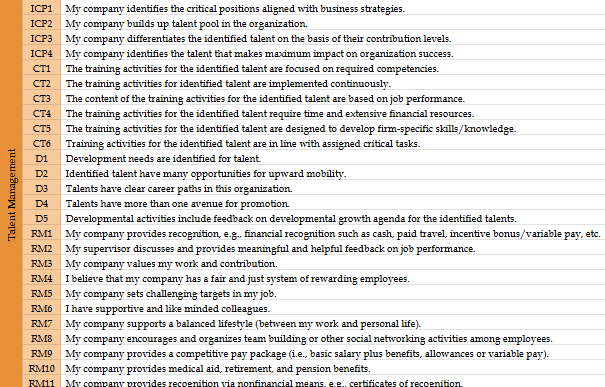

2. `Job Embeddedness` - This refers to the quality perceived by the employees in an organization.


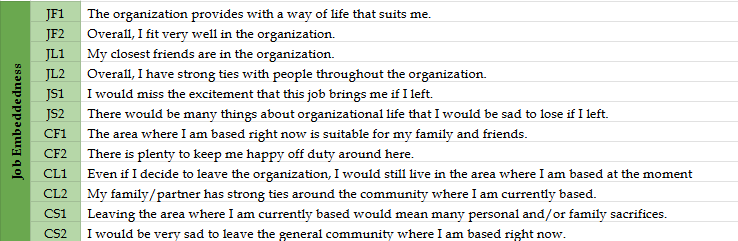

3. `Employee Retention` - this refers to the intention of an employee whether leaving or staying in an organization.

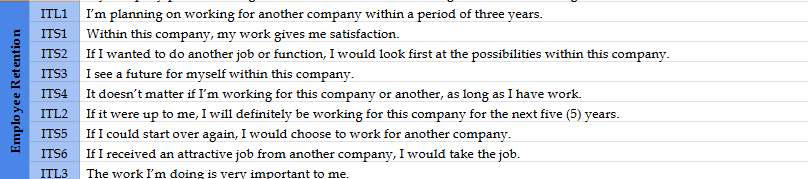

# **Data Preparation**

In [53]:
retention_df["HighestEducationalAttainment"].unique()

array(["Bachelor's Degree", "Associate's Degree/Vocational/Diploma",
       "Master's Degree", 'High School (Before K-12)'], dtype=object)

In [54]:
def rename_education(value):
  # This function will shorten the name
  # of educational attainment.
  if value == "Bachelor's Degree":
    return "Bachelor"
  elif value == "Master's Degree":
    return "Master"
  elif value == "Postgraduate":
    return "Postgraduate"
  elif value == "Associate's Degree/Vocational/Diploma":
    return "Associate"
  else:
    return "High School"

retention_df["Education"] = retention_df["HighestEducationalAttainment"].apply(rename_education)

In [55]:
retention_df["YearsofService"].unique()

array(['11-15 Years', '16-20 Years', '6-10 Years', '1-5 Years',
       '21-25 Years', '26-30 Years'], dtype=object)

In [56]:
def remove_character(value, character):
  return value.replace(character, "")

retention_df["Tenure"] = retention_df["YearsofService"].apply(remove_character, character="Years")

In [57]:
retention_df["NatureofEmployment"].unique()

array(['Permanent', 'Contractual', 'Job Order/Contract of Service'],
      dtype=object)

In [58]:
def shorten_emp_type(value):
  if value == "Job Order/Contract of Service":
    return "JO/COS"
  elif value == "Permanent":
    return "RR"
  elif value == "Contractual":
    return "CT"
  else:
    return None

retention_df["Employee_type"] = retention_df["NatureofEmployment"].apply(shorten_emp_type)

In [59]:
retention_df.Organization.unique()

array(['Light Rail Transit Authority (LRTA)',
       'Metro Rail Transit 3 (DOTr-MRT3)'], dtype=object)

In [60]:
def shorten_org(value):
  if value == "Light Rail Transit Authority (LRTA)":
    return "LRTA"
  elif value == "Metro Rail Transit 3 (DOTr-MRT3)":
    return "MRT3"
  else:
    return None

retention_df["Railway_Operator"] = retention_df["Organization"].apply(shorten_org)

In [61]:
retention_df["Occupation"].unique()

array(['Government Employee', 'Tranport operations Supervisor B',
       'Transport Operations Supervisor B', 'Train Driver A',
       'Government employee', 'Train driver', 'GOVERNMENT EMPLOYEE',
       'Safety Specialist', 'Train Driver', 'Train driver A', nan,
       'train driver A', 'Employee', 'Train Drive',
       'Transport operations supervisor', 'Cso B',
       'Traansport Operations Supervisor B', 'Civil Security Officer',
       'CSO B', 'Lrta employee', 'Civil Security Officer B',
       'Civil Security Officer -B', 'Transport Operation Supervisor B',
       'Driver', 'Transport Officer A', 'Gov. Employee',
       'Transport officer  A', 'Toa', 'TRANSPORT OFFICER A',
       'Govt Employee', 'Transport officer A', 'STDO', 'train driver',
       'Train Deiver', 'Transport Operations', 'SUPERVISOR',
       'Transport supervisor', 'LRTA Employee', 'Transport Supervisor',
       'DOTr MRT3 TRAIN DRIVER', 'Train Driver/Operator',
       'Senior transportation development officer

In [62]:
def classify_job_level(position):
    if isinstance(position, str):
      position = position.lower()  # Convert to lowercase for case-insensitive matching
      if "supervisor" in position or " a" in position:
          return "Managerial"
      elif "senior" in position or "iii" in position or "3" in position or "stdo" in position or "b" in position:
          return "Senior"
      elif "c" in position:
          return "Junior"
      else:
          return "Junior"
    else:
      return "Unknown"

retention_df["Job Level"] = retention_df["Occupation"].apply(classify_job_level)

In [63]:
retention_prepped_df = retention_df.drop(columns=["HighestEducationalAttainment", "YearsofService", "NatureofEmployment", "Organization", "Occupation"])
retention_prepped_df.sample(3)

,Age,Sex,JF1,JF2,JL1,JL2,JS1,JS2,CF1,CF2,...,ITS4,ITL2,ITS5,ITS6,ITL3,Education,Tenure,Employee_type,Railway_Operator,Job Level
117,56-60,Male,3,4,5,4,4,4,4,4,...,3,3,3,4,3,Bachelor,16-20,RR,LRTA,Junior
72,26-30,Male,4,4,4,4,4,4,4,4,...,4,3,4,4,3,Bachelor,6-10,CT,MRT3,Junior
242,46-50,Male,4,4,3,4,3,4,3,3,...,3,3,3,3,3,Associate,16-20,CT,MRT3,Junior


# **Visualization: Demographics**

In [64]:
def plot_sex_distrib(feature, data=retention_df):
  gender_employment_nature = retention_df.groupby(["Sex", feature]).size().reset_index(name="Count")
  total_count = gender_employment_nature["Count"].sum()
  gender_employment_nature["Percentage"] = (gender_employment_nature["Count"] / total_count) * 100
  fig, ax = plt.subplots(figsize=(8, 6))
  sns.barplot(data=gender_employment_nature, x=feature, y="Count", hue="Sex", ax=ax)

  # place percentage per plot
  for p in ax.patches:
    height = p.get_height()
    if height == 0:
      return None
    else:
      ax.annotate(f"{height/total_count:.1%}",  # Convert to percentage format
                  (p.get_x() + p.get_width() / 2., height),  # Positioning
                  ha='center', va='bottom', fontsize=10, color='black')

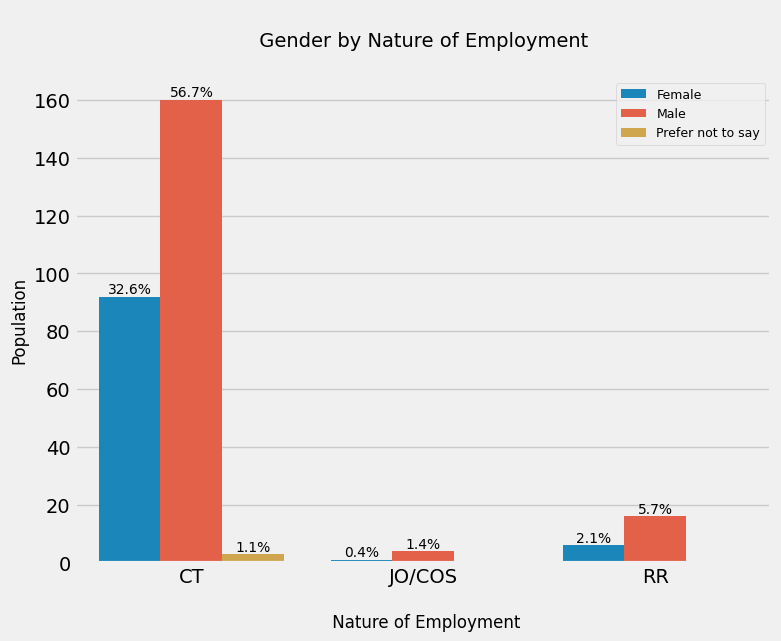

In [65]:
style.use("fivethirtyeight")
plot_sex_distrib("Employee_type")
plt.title("\n Gender by Nature of Employment \n", fontsize=14)
plt.xlabel("\n Nature of Employment", fontsize=12)
plt.ylabel("Population", fontsize=12)
plt.legend(fontsize=9)
plt.show()

Text(0, 0.5, 'Population')

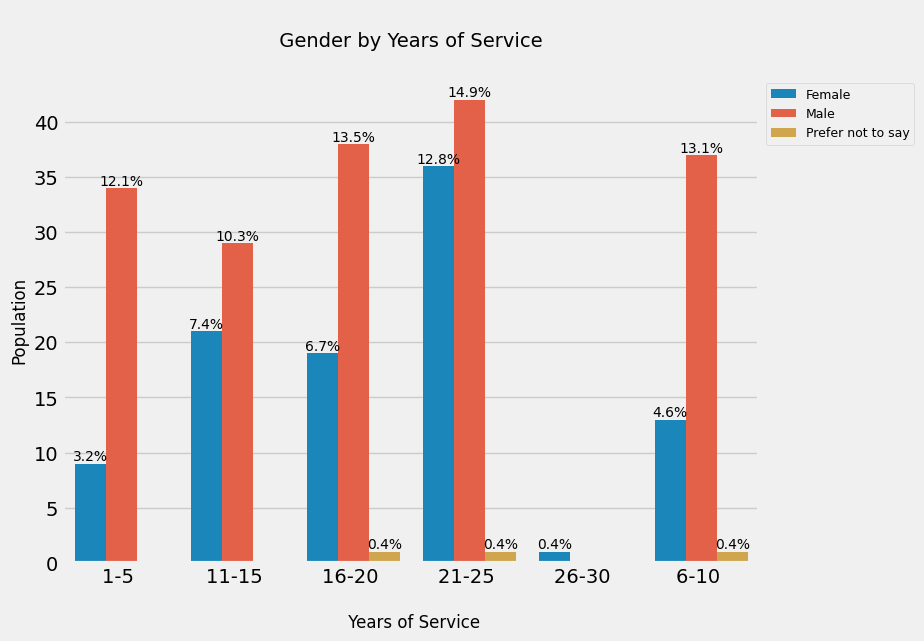

In [66]:
plot_sex_distrib("Tenure")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)
plt.title("\n Gender by Years of Service \n" , fontsize=14)
plt.xlabel("\n Years of Service", fontsize=12)
plt.ylabel("Population", fontsize=12)

Text(0, 0.5, 'Population')

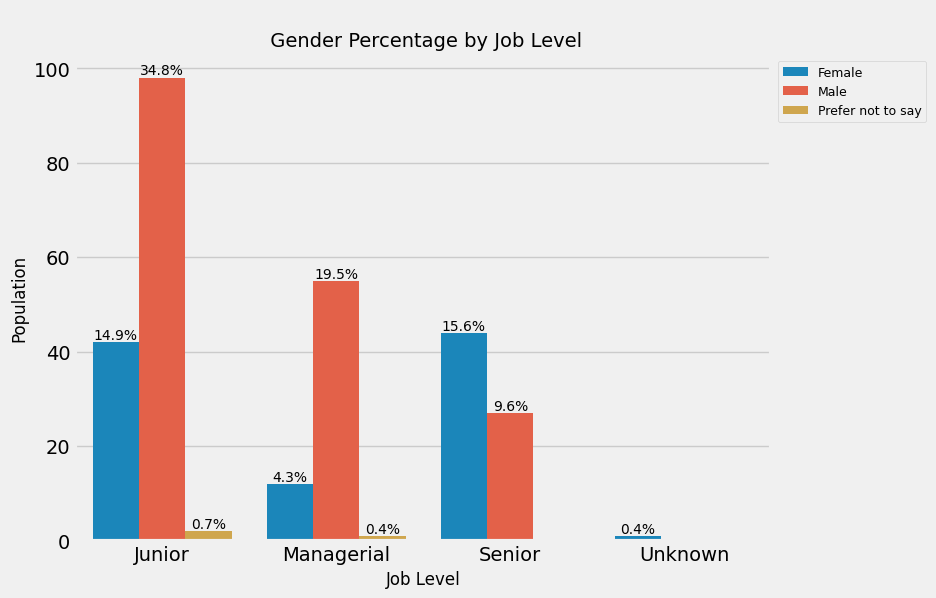

In [67]:
plot_sex_distrib("Job Level")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)
plt.title("\n Gender Percentage by Job Level", fontsize=14)
plt.xlabel("Job Level", fontsize=12)
plt.ylabel("Population", fontsize=12)

Text(0, 0.5, 'Population')

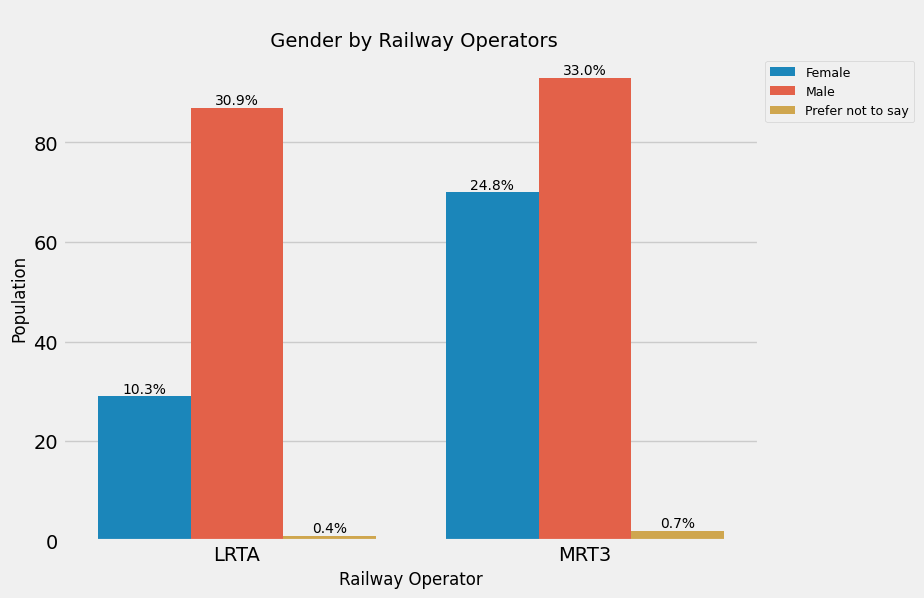

In [68]:
plot_sex_distrib("Railway_Operator")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)
plt.title("\n Gender by Railway Operators", fontsize=14)
plt.xlabel("Railway Operator", fontsize=12)
plt.ylabel("Population", fontsize=12)

Text(0.5, 1.0, '\n Gender Percentage by Educational Level \n')

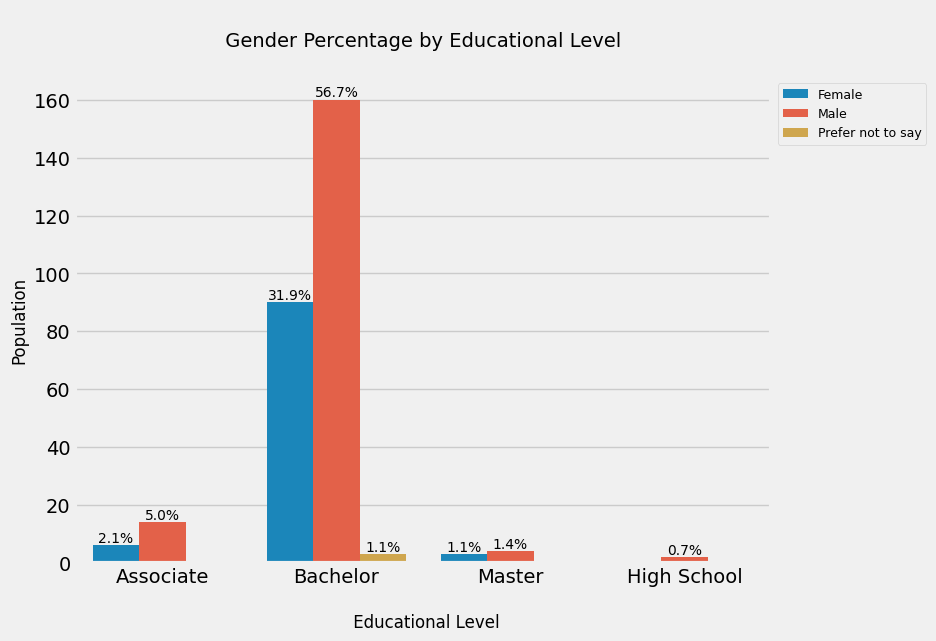

In [69]:
plot_sex_distrib("Education")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)
plt.ylabel("Population", fontsize=12)
plt.xlabel("\n Educational Level", fontsize=12)
plt.title("\n Gender Percentage by Educational Level \n", fontsize=14)

## **Education vs Demographics**

In [70]:
def plot_educ_distrib(feature, data=retention_df):
  gender_employment_nature = retention_prepped_df.groupby(["Education", feature]).size().reset_index(name="Count")
  total_count = gender_employment_nature["Count"].sum()
  gender_employment_nature["Percentage"] = (gender_employment_nature["Count"] / total_count) * 100
  fig, ax = plt.subplots(figsize=(8, 6))
  sns.barplot(data=gender_employment_nature, x=feature, y="Count", hue="Education", ax=ax)

  # place percentage per plot
  for p in ax.patches:
    height = p.get_height()
    if height == 0:
      return None
    else:
      ax.annotate(f"{height/total_count:.1%}",  # Convert to percentage format
                  (p.get_x() + p.get_width() / 2., height),  # Positioning
                  ha='center', va='bottom', fontsize=10, color='black')

Text(0, 0.5, 'Population')

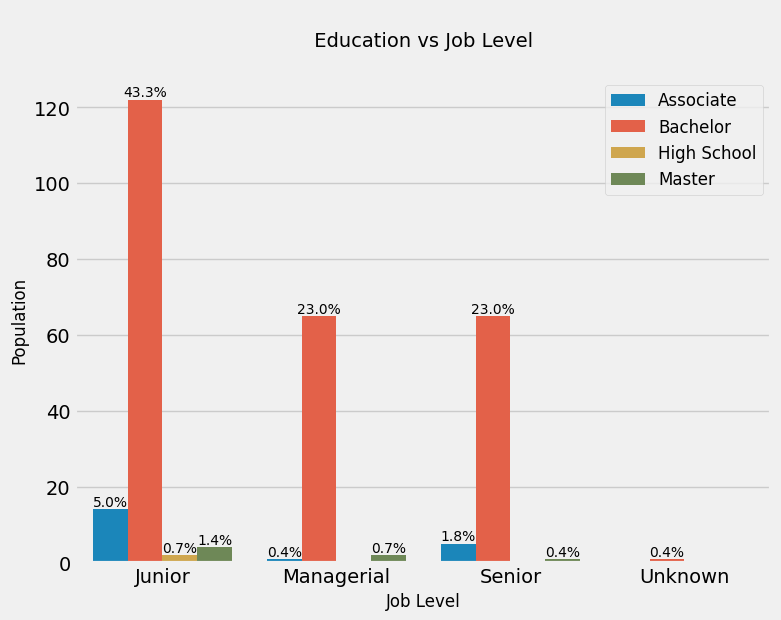

In [71]:
plot_educ_distrib("Job Level")
plt.legend(fontsize=12)
plt.title("\n Education vs Job Level \n", fontsize=14)
plt.xlabel("Job Level", fontsize=12)
plt.ylabel("Population", fontsize=12)

Text(0, 0.5, 'Population')

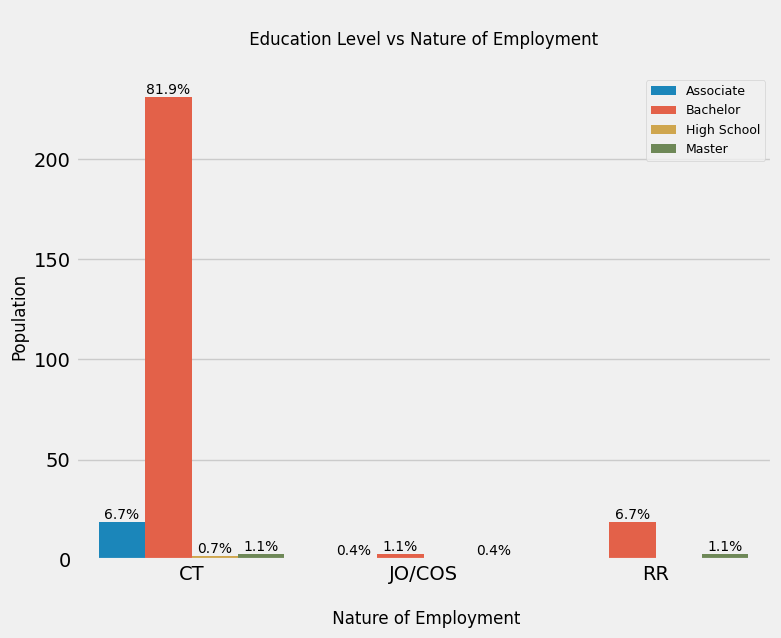

In [72]:
plot_educ_distrib("Employee_type")
plt.legend(fontsize=9)
plt.title("\n Education Level vs Nature of Employment \n", fontsize=12)
plt.xlabel("\n Nature of Employment", fontsize=12)
plt.ylabel("Population", fontsize=12)

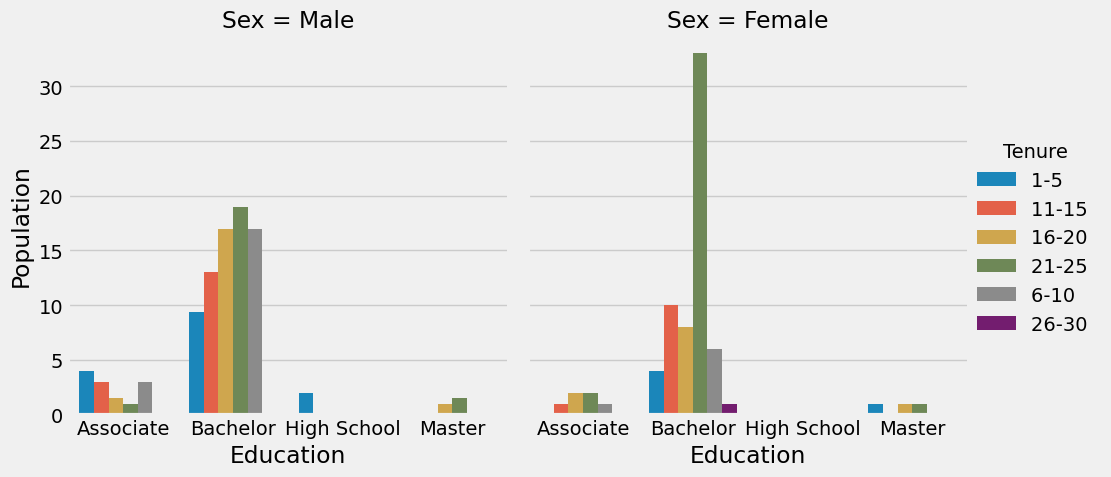

In [73]:
emp_educ_years = retention_prepped_df.groupby(["Employee_type", "Education", "Tenure", "Sex"]).count()["Job Level"].reset_index()
emp_educ_years.rename(columns={"Job Level":"Population"}, inplace=True)
emp_educ_years = emp_educ_years[(emp_educ_years["Sex"]=="Female") | (emp_educ_years["Sex"]=="Male")]
style.use("fivethirtyeight")
fig = sns.catplot(emp_educ_years,
                  x="Education",
                  hue="Tenure",
                  y="Population",
                  kind="bar",
                  # height=4
                  ci=False,
                  col="Sex")

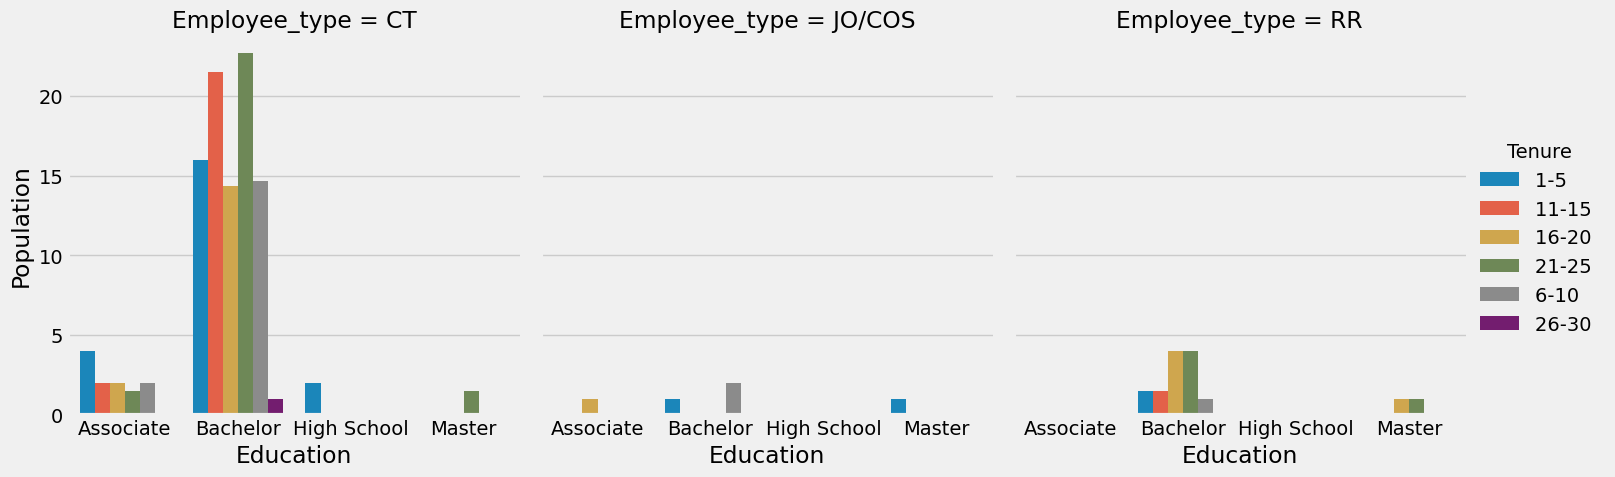

In [74]:
emp_educ_years = retention_prepped_df.groupby(["Employee_type", "Education", "Tenure", "Sex"]).count()["Job Level"].reset_index()
emp_educ_years.rename(columns={"Job Level":"Population"}, inplace=True)
style.use("fivethirtyeight")
fig = sns.catplot(emp_educ_years,
                  x="Education",
                  col="Employee_type",
                  y="Population",
                  kind="bar",
                  ci=False,
                  # height=4, aspect=.8, col_wrap=8,
                  hue="Tenure")

# **Feature Engineering**

In order to proceed to Machine Learning Modeling, we have to encode or label our talent retention responses. As we can see, the responses are in the form of likert scale numbers, whereas 5 represents `greatly agree`, 4 as `agree`, 3 as `neutral`, 2 as `disagree`, and 1 as `greatly disagree`. To minimize the variability and bias between this responses, we will create a simple binary classification such as that:
- `1` will represent 5 and 4, that can be translated to high opinion.
- `-1` will represent 2, and 1, that can be translated to low opinion.
- `0` will represent 3, that can be translated to neutral opinion

we include 3 or neutral to low opinion because the latter represent that lack of opinion to the question given.

In [75]:
def convert_scale(value):
  if (value == 5) or (value == 4):
    return 1
  elif (value == 2) or (value == 1):
    return -1
  else:
    return 0

In [76]:
# Segregate the dataset
TM_features = retention_prepped_df[['ICP1', 'ICP2', 'ICP3', 'ICP4', 'CT1', 'CT2', 'CT3', 'CT4', 'CT5', 'CT6', 'D1',
       'D2', 'D3', 'D4', 'D5', 'RM1', 'RM2', 'RM3', 'RM4', 'RM5', 'RM6', 'RM7',
       'RM8', 'RM9', 'RM10', 'RM11']]

JE_features = retention_prepped_df[['JF1', 'JF2', 'JL1',
       'JL2', 'JS1', 'JS2', 'CF1', 'CF2', 'CL1', 'CL2', 'CS1', 'CS2']]

ER_features = retention_prepped_df[['ITL1', 'ITS1', 'ITS2', 'ITS3', 'ITS4',
       'ITL2', 'ITS5', 'ITS6', 'ITL3']]

In [77]:
# Encode dataset
TM_features_encode = TM_features.applymap(convert_scale)
JE_features_encode = JE_features.applymap(convert_scale)
ER_features_encode = ER_features.applymap(convert_scale)

In [78]:
retention_prepped_df.columns

Index(['Age', 'Sex', 'JF1', 'JF2', 'JL1', 'JL2', 'JS1', 'JS2', 'CF1', 'CF2',
       'CL1', 'CL2', 'CS1', 'CS2', 'ICP1', 'ICP2', 'ICP3', 'ICP4', 'CT1',
       'CT2', 'CT3', 'CT4', 'CT5', 'CT6', 'D1', 'D2', 'D3', 'D4', 'D5', 'RM1',
       'RM2', 'RM3', 'RM4', 'RM5', 'RM6', 'RM7', 'RM8', 'RM9', 'RM10', 'RM11',
       'ITL1', 'ITS1', 'ITS2', 'ITS3', 'ITS4', 'ITL2', 'ITS5', 'ITS6', 'ITL3',
       'Education', 'Tenure', 'Employee_type', 'Railway_Operator',
       'Job Level'],
      dtype='object')

In [79]:
retention_prepped_df.Sex.unique()

array(['Male', 'Female', 'Prefer not to say'], dtype=object)

In [80]:
age_list = retention_prepped_df.Age
education_list = retention_prepped_df.Education
tenure_list = retention_prepped_df.Tenure
employee_type_list = retention_prepped_df.Employee_type

In [81]:
demographics_df = pd.DataFrame()
# Ordinal Encoding
demographics_df["Age"] = age_list.map({'21-25':1, '26-30':2, '31-35':3, '36-40':4, '41-45':5, '46-50':6, '51-55':7, '56-60':8, '61-65':9})
demographics_df["Education"] = education_list.map({'High School':1, 'Associate':2, 'Bachelor':3, 'Master':4})
demographics_df["Tenure"] = tenure_list.map({'1-5 ':1, '6-10 ':2, '11-15 ':3, '16-20 ':4, '21-25 ':5, '26-30 ':6})
demographics_df["Employee Type"] = employee_type_list.map({'JO/COS': 1, 'CT':2, 'RR':3})

# One-hot encoding
demographics_df["Railway Operator"] = pd.get_dummies(retention_prepped_df.Railway_Operator, drop_first=True)
gender = pd.get_dummies(retention_prepped_df.Sex)

# Combine
demographics_df = pd.concat([demographics_df, gender], axis=1)
demographics_df.sample(5)

,Age,Education,Tenure,Employee Type,Railway Operator,Female,Male,Prefer not to say
251,7,3,5,2,True,True,False,False
34,6,3,4,2,False,False,True,False
20,4,3,3,2,False,False,True,False
162,5,3,3,2,False,True,False,False
63,4,3,3,2,False,False,True,False


In [82]:
demographics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Age                282 non-null    int64
 1   Education          282 non-null    int64
 2   Tenure             282 non-null    int64
 3   Employee Type      282 non-null    int64
 4   Railway Operator   282 non-null    bool 
 5   Female             282 non-null    bool 
 6   Male               282 non-null    bool 
 7   Prefer not to say  282 non-null    bool 
dtypes: bool(4), int64(4)
memory usage: 10.0 KB


# **Modeling Part 1**

## **Clustering Talent Management Features**

In this part, we will create a cluster modeling using the Talent Management features to create a new feature that will represent all talent management features for our final predictive model. We will test the result of this TM cluster to the Job Embeddedness Classes.

In [83]:
# import kmeans and dbscan
from sklearn.cluster import KMeans

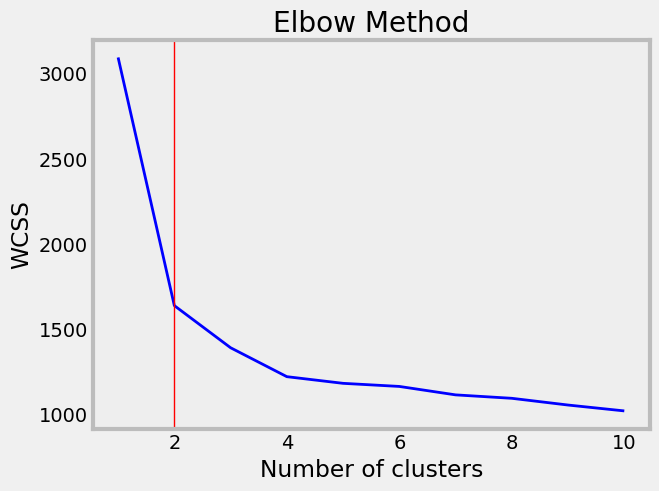

In [84]:
# Determine & graph the optimal number of clusters for Talent Mgmt
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(TM_features_encode)
    wcss.append(kmeans.inertia_)

style.use("bmh")
plt.plot(range(1, 11), wcss, color='blue')
plt.grid()
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.axvline(x=2, ymin=0, ymax = 3000, linewidth=1, color='r')
plt.show()

In [85]:
# Fit kmeans to determine TM level
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
TM_level = kmeans.fit_predict(TM_features_encode)

# Create TM Level feature
TM_features["Perceived TM Level"] = TM_level
TM_features_encode["Perceived TM Level"] = TM_level

<ipython-input-85-f9217e7cf5cf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TM_features["Perceived TM Level"] = TM_level


## **Feature Importance: TM Level**

In [86]:
# Feature importance for cluster analysis
from sklearn.metrics import silhouette_score

exc_tm = TM_features_encode.drop("Perceived TM Level", axis=1)
kmeans_ = KMeans(n_clusters=2).fit(exc_tm)
original_score = silhouette_score(exc_tm, kmeans_.labels_)
ret_cols = exc_tm.columns
TM_importance_df = pd.DataFrame({})

for i in range(exc_tm.shape[1]):
  X_reduced = np.delete(exc_tm, i, axis=1)
  kmeans_.fit(X_reduced)
  new_score = silhouette_score(X_reduced, kmeans_.labels_)
  impact = original_score - new_score
  # populate TM importance dataframe
  # Append results to DataFrame
  TM_importance_df = pd.concat([TM_importance_df, pd.DataFrame([[ret_cols[i], impact]], columns=["Feature", "Impact"])], ignore_index=True)

Text(0.5, 1.0, '\n Feature importance for the Level of Perceived Talent Management \n')

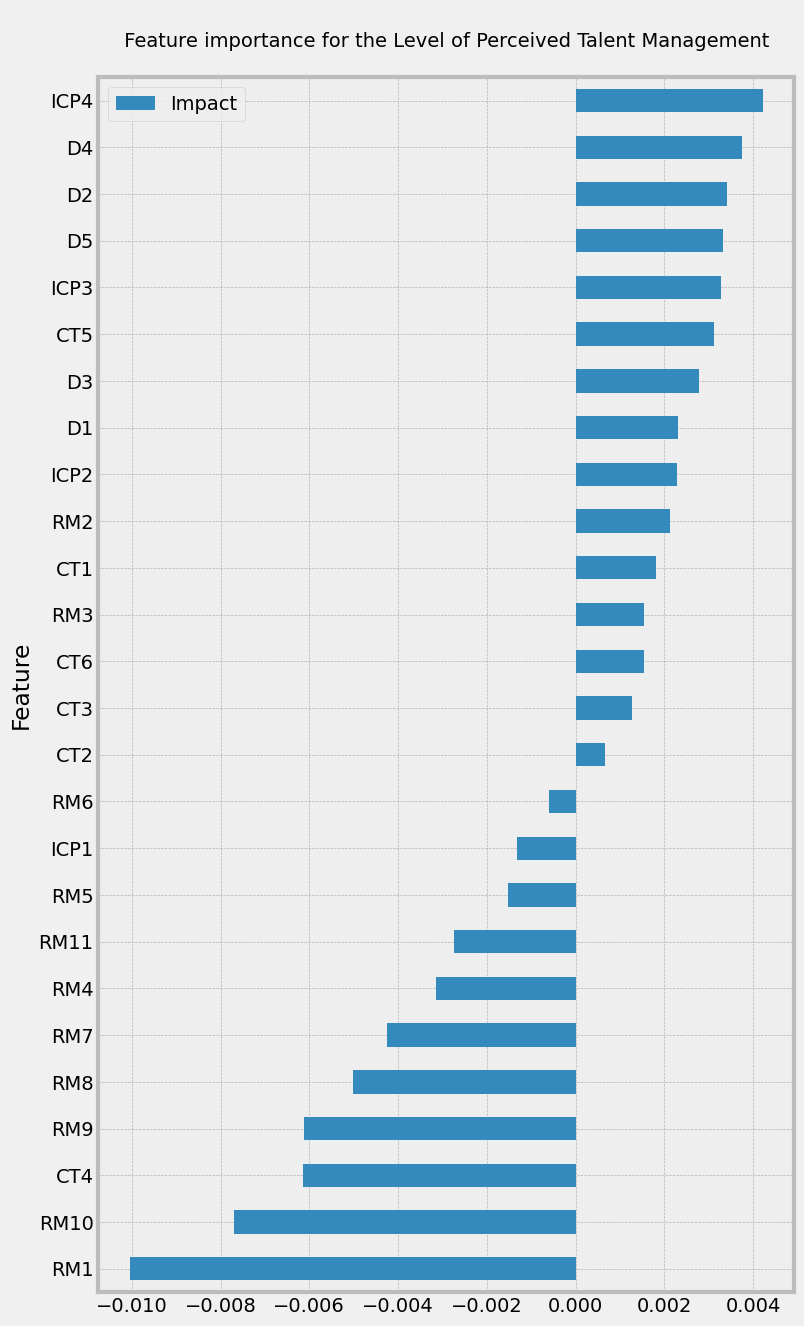

In [87]:
# Print final TM importance DataFrame
TM_importance_df.sort_values(by="Impact", ascending=True, inplace=True)
# TM_importance_df["Impact"] = pd.to_numeric(TM_importance_df["Impact"])
TM_importance_df.set_index("Feature", inplace=True)
TM_importance_df.plot(kind="barh", figsize=(8, 15))
style.use("fivethirtyeight")
plt.title("\n Feature importance for the Level of Perceived Talent Management \n", fontsize=14)

In [88]:
TM_importance_df.reset_index(inplace=True)
TM_importance_df = TM_importance_df.sort_values(by="Impact", ascending=False)
TM_importance_df

,Feature,Impact
25,ICP4,0.004217
24,D4,0.003749
23,D2,0.003408
22,D5,0.003321
21,ICP3,0.003266
20,CT5,0.003120
19,D3,0.002784
18,D1,0.002316
17,ICP2,0.002282
16,RM2,0.002126


In [89]:
D3_TM_lvl = TM_features_encode.groupby(["D3", "Perceived TM Level"]).count()["RM1"].reset_index()
D2_TM_lvl = TM_features_encode.groupby(["D2", "Perceived TM Level"]).count()["RM1"].reset_index()
CT5_TM_lvl = TM_features_encode.groupby(["CT5", "Perceived TM Level"]).count()["RM1"].reset_index()
RM1_TM_lvl = TM_features_encode.groupby(["RM1", "Perceived TM Level"]).count()["RM2"].reset_index()
RM10_TM_lvl = TM_features_encode.groupby(["RM10", "Perceived TM Level"]).count()["RM2"].reset_index()

<ipython-input-90-abc2630787bf>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(["Low Opinion", "Neutral Opinion" ,"High Opinion"])
<ipython-input-90-abc2630787bf>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,1].set_xticklabels(["Low Opinion", "Neutral Opinion", "High Opinion"])
<ipython-input-90-abc2630787bf>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,0].set_xticklabels(["Low Opinion", "Neutral Opinion", "High Opinion"])
<ipython-input-90-abc2630787bf>:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,1].set_xticklabels(["Low Opinion", "Neutral Opinion", "High Opinion"])


[Text(0, 0, 'Low Opinion'),
 Text(1, 0, 'Neutral Opinion'),
 Text(2, 0, 'High Opinion')]

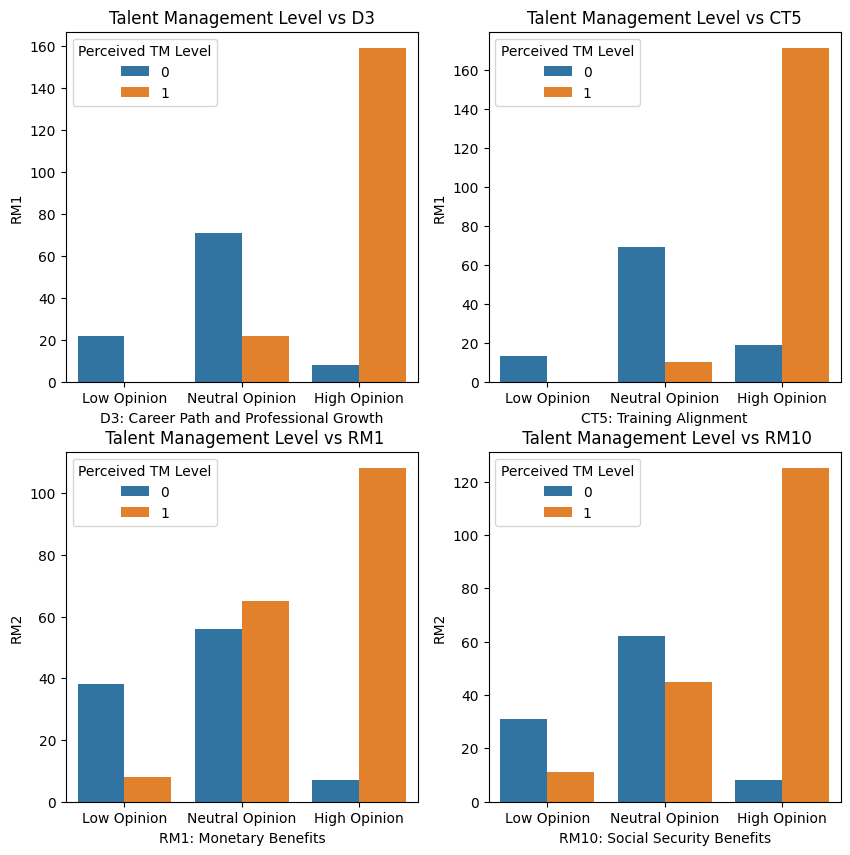

In [90]:
style.use("default")
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.barplot(data=D3_TM_lvl, x="D3", y="RM1", hue="Perceived TM Level", ax=axes[0,0])
axes[0,0].set_title("Talent Management Level vs D3")
axes[0,0].set_xlabel("D3: Career Path and Professional Growth")
axes[0,0].set_xticklabels(["Low Opinion", "Neutral Opinion" ,"High Opinion"])

sns.barplot(data=CT5_TM_lvl, x="CT5", y="RM1", hue="Perceived TM Level", ax=axes[0,1])
axes[0,1].set_title("Talent Management Level vs CT5")
axes[0,1].set_xlabel("CT5: Training Alignment")
axes[0,1].set_xticklabels(["Low Opinion", "Neutral Opinion", "High Opinion"])

sns.barplot(data=RM1_TM_lvl, x="RM1", y="RM2", hue="Perceived TM Level", ax=axes[1,0])
axes[1,0].set_title("\n Talent Management Level vs RM1")
axes[1,0].set_xlabel("RM1: Monetary Benefits")
axes[1,0].set_xticklabels(["Low Opinion", "Neutral Opinion", "High Opinion"])

sns.barplot(data=RM10_TM_lvl, x="RM10", y="RM2", hue="Perceived TM Level", ax=axes[1,1])
axes[1,1].set_title("\n Talent Management Level vs RM10")
axes[1,1].set_xlabel("RM10: Social Security Benefits")
axes[1,1].set_xticklabels(["Low Opinion", "Neutral Opinion", "High Opinion"])

## **Clustering Job Embeddedness**

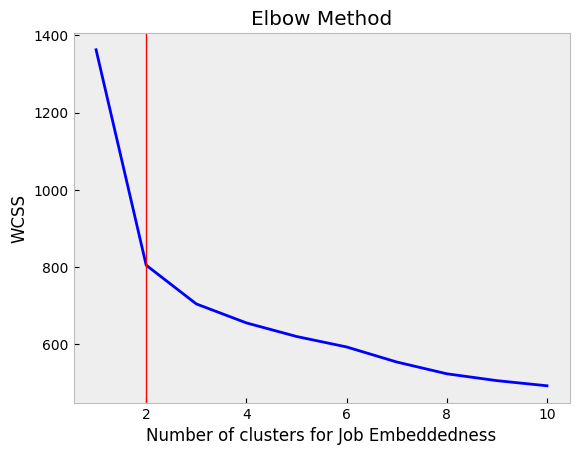

In [91]:
# Determine & graph the optimal number of clusters for Talent Mgmt
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(JE_features_encode)
    wcss.append(kmeans.inertia_)

style.use("bmh")
plt.plot(range(1, 11), wcss, color='blue')
plt.grid()
plt.title('Elbow Method')
plt.xlabel('Number of clusters for Job Embeddedness')
plt.ylabel('WCSS')
plt.axvline(x=2, ymin=0, ymax = 3000, linewidth=1, color='r')
plt.show()

In [92]:
# Fit kmeans to determine TM level
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
JE_level = kmeans.fit_predict(JE_features_encode)

# Create TM Level feature
JE_features["Perceived JE Level"] = JE_level
JE_features_encode["Perceived JE Level"] = JE_level

<ipython-input-92-28cda0fb971e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  JE_features["Perceived JE Level"] = JE_level


## **Feature Importance: JE Level**

Text(0.5, 1.0, '\n Feature importance for the Level of Perceived Job Embeddedness \n')

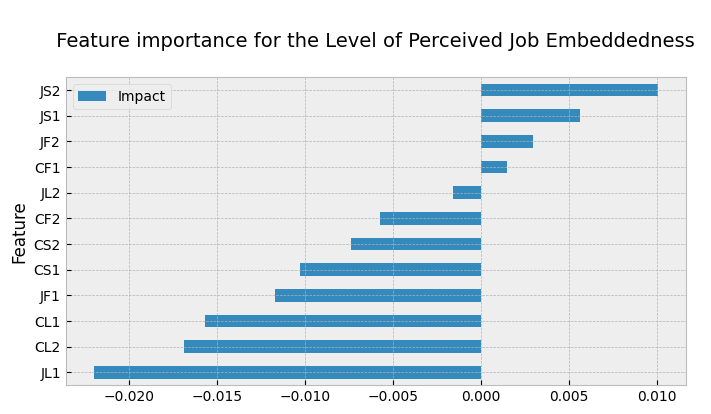

In [93]:
exc_tm = JE_features_encode.drop("Perceived JE Level", axis=1)
kmeans_ = KMeans(n_clusters=2).fit(exc_tm)
original_score = silhouette_score(exc_tm, kmeans_.labels_)
ret_cols = exc_tm.columns
JE_importance_df = pd.DataFrame({})

# List feature impact
for i in range(exc_tm.shape[1]):
  X_reduced = np.delete(exc_tm, i, axis=1)
  kmeans_.fit(X_reduced)
  new_score = silhouette_score(X_reduced, kmeans_.labels_)
  impact = original_score - new_score
  # populate TM importance dataframe
  # Append results to DataFrame
  JE_importance_df = pd.concat([JE_importance_df, pd.DataFrame([[ret_cols[i], impact]], columns=["Feature", "Impact"])], ignore_index=True)

# Print final TM importance DataFrame
JE_importance_df.sort_values(by="Impact", ascending=True, inplace=True)

# TM_importance_df["Impact"] = pd.to_numeric(TM_importance_df["Impact"])
JE_importance_df.set_index("Feature", inplace=True)
JE_importance_df.plot(kind="barh", figsize=(8, 4))
style.use("fivethirtyeight")
plt.title("\n Feature importance for the Level of Perceived Job Embeddedness \n", fontsize=14)

In [94]:
JE_importance_df.reset_index(inplace=True)
JE_importance_df = JE_importance_df.sort_values(by="Impact", ascending=False)
JE_importance_df

,Feature,Impact
11,JS2,0.010062
10,JS1,0.005670
9,JF2,0.002961
8,CF1,0.001516
7,JL2,-0.001604
6,CF2,-0.005717
5,CS2,-0.007386
4,CS1,-0.010261
3,JF1,-0.011693
2,CL1,-0.015662


## **Test of independence: TM and JE**

In [95]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 13.7 MB/s eta 0:00:00


In [96]:
# chi-square test of independence between JE_cat and kmeans_grp using pingouin
# signifance or alpha = 0.05
import pingouin as pg
JE_features_encode["Perceived TM Level"] = TM_features_encode["Perceived TM Level"]
exp, obs, stats = pg.chi2_independence(JE_features_encode,
                                       x='Perceived JE Level', y='Perceived TM Level')
# print()
pd.DataFrame(stats[stats['test'] == 'pearson'])

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.0,61.782465,1.0,3.835749e-15,0.468067,1.0


- There is a statistically significant relationship between perceived job embeddedness and perceived talent management (p < 0.05).

- The effect size (Cramér’s V = 0.468) suggests a moderate-to-strong relationship between these two factors.

- The test had high reliability (Power = 1.0), meaning the results are robust.

In [104]:
ER_features_encode

,ITL1,ITS1,ITS2,ITS3,ITS4,ITL2,ITS5,ITS6,ITL3
0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,0,0,1,1,0
2,1,1,1,1,0,0,1,1,1
3,0,1,0,1,0,0,1,1,0
4,0,1,1,1,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...
277,0,0,0,0,0,0,0,0,1
278,0,1,1,0,1,-1,1,1,1
279,1,1,1,1,1,1,1,1,1
280,1,1,1,1,1,0,1,1,1


In [98]:
JE_features_encode[["Perceived TM Level", "Perceived JE Level"]]

,Perceived TM Level,Perceived JE Level
0,0,0
1,0,1
2,1,1
3,1,1
4,1,1
...,...,...
277,0,1
278,0,1
279,1,1
280,1,1


In [110]:
from collections import Counter

def evaluate_row(row):
    counter = Counter(row)
    most_common = counter.most_common()

    # If the highest occurring value appears at least twice, return it
    if most_common[0][1] >= 2:
        return most_common[0][0]
    return 0  # Default output when all values are different

def evaluate_dataframe(df, col1, col2, col3):
    """
    Takes a DataFrame and three column names, evaluates row-wise based on the given logic.
    """
    df['output'] = df[[col1, col2, col3]].apply(evaluate_row, axis=1)
    return df["output"]

In [112]:
JE_features_encode["llh_to_leave"] = evaluate_dataframe(ER_features_encode, 'ITL1', 'ITS5', 'ITS6')

In [114]:
JE_features_encode[["Perceived TM Level", "Perceived JE Level", "llh_to_leave"]]

,Perceived TM Level,Perceived JE Level,llh_to_leave
0,0,0,0
1,0,1,1
2,1,1,1
3,1,1,1
4,1,1,1
...,...,...,...
277,0,1,0
278,0,1,1
279,1,1,1
280,1,1,1


In [117]:
JE_features_encode.groupby(["Perceived TM Level", "Perceived JE Level"]).count()["llh_to_leave"].reset_index()

,Perceived TM Level,Perceived JE Level,llh_to_leave
0,0,0,64
1,0,1,37
2,1,0,30
3,1,1,151


In [120]:
JE_features_cols = JE_features_encode[["Perceived TM Level", "Perceived JE Level", "llh_to_leave"]]

In [123]:
employee_turnover = pd.concat([demographics_df, JE_features_cols], axis=1)
employee_turnover.head()

,Age,Education,Tenure,Employee Type,Railway Operator,Female,Male,Prefer not to say,Perceived TM Level,Perceived JE Level,llh_to_leave
0,4,3,3,3,False,False,True,False,0,0,0
1,6,3,4,2,False,False,True,False,0,1,1
2,4,3,3,2,False,False,True,False,1,1,1
3,6,3,4,2,False,False,True,False,1,1,1
4,2,3,2,2,False,False,True,False,1,1,1


In [135]:
# convert -1 from llh_to_leave to 2
employee_turnover["llh_to_leave"] = employee_turnover["llh_to_leave"].replace(-1, 2)

# **Modeling 2: Multiclass-Classification**

In [131]:
# Import API for ML classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import pydot
from imblearn.over_sampling import SMOTE

In [136]:
X = employee_turnover.drop("llh_to_leave", axis=1)
y = employee_turnover["llh_to_leave"]

# SMOTE
method = SMOTE()
X_resample, y_resample = method.fit_resample(X, y)

# Split Train and Test Data
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.2, random_state=42)

In [137]:
# Fit and predict Decision Tree Model
dt_model = DecisionTreeClassifier(max_depth=10,random_state=42)
dt_model.fit(X_train, y_train)
dt_JE_pred = dt_model.predict(X_test)

In [138]:
# Fit and predict Random Forest Classifier model
rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_model.fit(X_train, y_train)
rfc_JE_pred = rfc_model.predict(X_test)

In [139]:
# Fit and predict Bayesian Classifier model
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)
gnb_JE_pred = gnb_model.predict(X_test)

In [140]:
# Fit KNN classifier
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)
knn_JE_pred = knn_model.predict(X_test)

In [141]:
# Fit Logistic Regression
logreg_model = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
logreg_model.fit(X_train, y_train)
logreg_JE_pred = logreg_model.predict(X_test)

In [142]:
# Fit and predict Gradient Boosted Classifier model
xgb_model = XGBClassifier(max_depth=5,
                          learning_rate=0.05,
                          n_estimators=1000,
                          gamma=10,
                          min_child_weight=1,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          reg_alpha=0.0005,
                          early_stopping_rounds=3)

xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)
xgb_JE_pred = xgb_model.predict(X_test)

In [143]:
from sklearn.metrics import accuracy_score, confusion_matrix
dt_ac_score = accuracy_score(y_test, dt_JE_pred)
rfc_ac_score = accuracy_score(y_test, rfc_JE_pred)
gnb_ac_score = accuracy_score(y_test, gnb_JE_pred)
knn_ac_score = accuracy_score(y_test, knn_JE_pred)
logreg_ac_score = accuracy_score(y_test, logreg_JE_pred)
xgb_ac_score = accuracy_score(y_test, xgb_JE_pred)

print("Accuracy Score")
print("Decision Tree: ", dt_ac_score)
print("Random Forest: ", rfc_ac_score)
print("Naive Bayes: ", gnb_ac_score)
print("KNN: ", knn_ac_score)
print("Logistic Regression: ", logreg_ac_score)
print("XGBoost: ", xgb_ac_score)

Accuracy Score
Decision Tree:  0.7983193277310925
Random Forest:  0.8571428571428571
Naive Bayes:  0.5378151260504201
KNN:  0.8067226890756303
Logistic Regression:  0.8151260504201681
XGBoost:  0.8067226890756303


In [144]:
def get_confusion_matrix(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  return pd.DataFrame(cm, columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"])

In [146]:
# Logistic Regression Accuracy Score
logreg_train_score = logreg_model.score(X_train, y_train)
logreg_test_score = logreg_model.score(X_test, y_test)

print("Training Score: ", logreg_train_score)
print("Testing Score: ", logreg_test_score)

Training Score:  0.7663157894736842
Testing Score:  0.8151260504201681


In [147]:
# Random Forest Accuracy Score
rfc_train_score = rfc_model.score(X_train, y_train)
rfc_test_score = rfc_model.score(X_test, y_test)

print("Training Score: ", rfc_train_score)
print("Testing Score: ", rfc_test_score)

Training Score:  0.9221052631578948
Testing Score:  0.8571428571428571


- Logistic regression model generalizes well compare to the random forest. Since the training score of RF is higher than testing score, it suggest overfitting.

In [149]:
# cross validation for logistic regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(logreg_model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.750 (0.035)


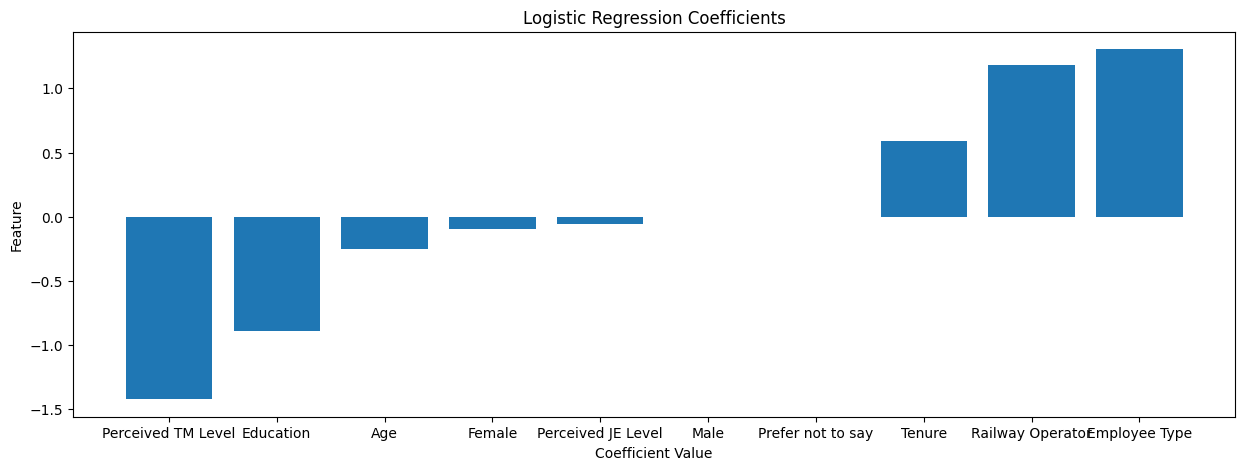

In [156]:
model_interpretation = pd.DataFrame(
    {"features": X_train.columns,
    "coefficients": logreg_model.coef_[0]}
)

model_interpretation.sort_values(by="coefficients", ascending=True, inplace=True)

style.use("default")
plt.figure(figsize=(15, 5))
plt.bar(model_interpretation.features,
         model_interpretation.coefficients)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.show()

**Key Insights:**
1. Negative Coefficients (Left Side - Decrease in Outcome Probability)

  - Perceived TM (Talent Management) Level and Education have the strongest negative impact on the dependent variable.

  - This suggests that employees who perceive talent management positively or have higher education levels are less likely to leave (assuming the outcome is turnover intent).

2. Neutral to Slightly Negative Coefficients (Near Zero Impact)

  - Age, Female, Perceived JE (Job Embeddedness) Level, and Male have coefficients close to zero, indicating that these factors have little to no significant effect on the predicted outcome.

  - "Prefer not to say" (gender category) also falls in this range, meaning it does not meaningfully influence the prediction.

3. Positive Coefficients (Right Side - Increase in Outcome Probability)

  - Tenure, Railway Operator, and Employee Type have positive coefficients, meaning they increase the likelihood of the predicted outcome.

  - This suggests that employees with longer tenure or those classified under specific employee types (e.g., contractual vs. permanent) are more likely to indicate an intent to leave.